In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

import sys


In [2]:

#import custome modules
sys.path.append('../')

from scripts.get_missing_information import MissingInformation
from scripts.get_dataframe_information import DataFrameInformation
from scripts.ploting_utils import Plotters
from scripts.data_clean_handler import CleanData
from scripts import data_loader
from scripts.dvc_data_fetch import DataLoader
from scripts.feature_engineering import FeatureEngineering

feng = FeatureEngineering()
dvc_load = DataLoader()
cleaner = CleanData()
minfo = MissingInformation()
dinfo = DataFrameInformation()
pltu = Plotters(6,4)

## Fetch the dataframes from DVC

In [3]:
train_df = pd.read_csv('../data/merged/train.csv')
test_df = pd.read_csv('../data/merged/test.csv')

/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_69141/3228016339.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('../data/merged/train.csv')


In [4]:

# # First load the cleaned stores data
# data_path = 'data/cleaned/store.csv'
# version = 'store_v2'
# repo = '../'

# store_df = dvc_load.dvc_get_data(data_path, version, repo)

# # Then load the raw sales data
# data_path = 'data/merged/train.csv'
# version = 'train_v2'
# repo = '../'

# train_df = dvc_load.dvc_get_data(data_path, version, repo)

# # Finally load the test data
# data_path = 'data/merged/test.csv'
# version = 'test_v2'
# repo = '../'

# test_df = dvc_load.dvc_get_data(data_path, version, repo)


## Features correlation to target

In [5]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        41088 non-null  float64
 11  CompetitionOpenSinceMonth  41088 non-null  object 
 12  CompetitionOpenSinceYear   41088 non-null  float64
 13  Promo2                     41088 non-null  int

Sales                       1.000000
Customers                   0.894711
Open                        0.678472
Promo                       0.452345
SalesPerCustomer            0.186581
SchoolHoliday               0.085124
WeekOfYear                  0.052946
Store                       0.005126
CompetitionDistance        -0.025273
CompetitionOpenSinceYear   -0.038540
Promo2SinceWeek            -0.044143
Promo2                     -0.091040
Promo2SinceYear            -0.091056
DayOfWeek                  -0.462125
Name: Sales, dtype: float64

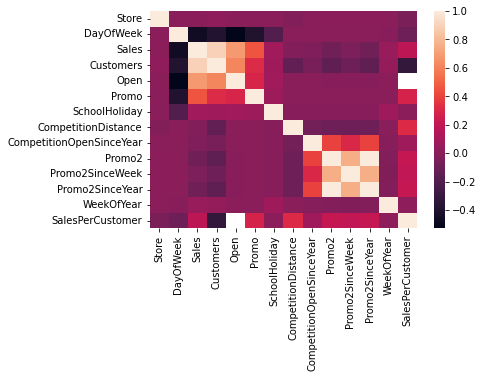

In [6]:
corr = train_df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)
corr['Sales'].sort_values(ascending=False)

Sales has highest correlation with Customers, and Open attributes. However, we don't have the 
Customers in our test data. So,Customers column should be droped and the same for the other columns missing in the test.

In [7]:
test_colunns = set(test_df.columns)
train_columns = set(train_df.columns)
common_columns = test_colunns.intersection(train_columns)

print('There are {} columns in the train and {} in the test. We have {} columns common in both train and test.'.format(len(train_columns), len(test_colunns), len(common_columns)))


There are 20 columns in the train and 17 in the test. We have 16 columns common in both train and test.


There are 22 columns in the train and 17 in the test. We have 16 columns common in both train and test. We should keep the common columns only

In [8]:
train_df.shape

(1017209, 20)

In [9]:
df = feng.drop_columns(train_df)
df.shape

FeatureEngineeringLogger - INFO - Dropped 1 columns since they are not in the test data


(1017209, 19)

In [10]:
holidays = feng._set_holidays(df)

FeatureEngineeringLogger - INFO - generatd holidays


In [11]:

df = feng.generate_columns(df)
df.head()

FeatureEngineeringLogger - INFO - 9 new columns added to the dataframe


,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,WeekOfYear,SalesPerCustomer,Year,Month,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,1,5,2015-07-31,5263,1,1,0,1,c,a,...,31,9.482883,2015,7,True,False,False,False,False,False
1,1,4,2015-07-30,5020,1,1,0,1,c,a,...,31,9.194139,2015,7,False,False,False,False,False,False
2,1,3,2015-07-29,4782,1,1,0,1,c,a,...,31,9.143403,2015,7,False,False,False,False,False,False
3,1,2,2015-07-28,5011,1,1,0,1,c,a,...,31,8.948214,2015,7,False,False,False,False,False,False
4,1,1,2015-07-27,6102,1,1,0,1,c,a,...,31,9.970588,2015,7,False,False,False,False,False,False


In [12]:
df = feng.create_holiday_distance_cols(df, holidays=holidays)
df.head()

In [ ]:
df['Sales'] = train_df['Sales']
df.info()


In [ ]:
import seaborn as sns
sns.heatmap(df.corr())
# preped_train_df['Sales']


In [ ]:
cleaner.get_numerical_columns(df)


In [ ]:
cleaner.get_categorical_columns(df)
